In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
import xarray as xr
import gc, glob
import pickle
from tqdm import tqdm
import pandas as pd

In [2]:
test = pd.read_csv('../number_of_clusters/cluster_15.csv')

In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9316 entries, 0 to 9315
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   9316 non-null   float64
 1   Longitude  9316 non-null   float64
 2   cluster    9316 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 218.5 KB


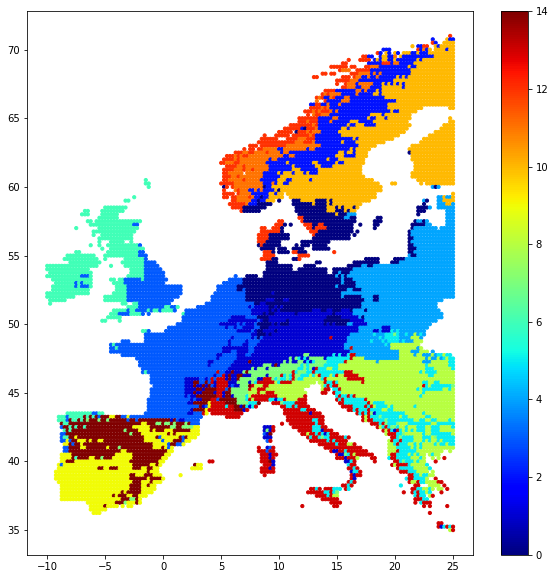

In [4]:
fig,ax = plt.subplots(figsize=(10,10))
aaa = ax.scatter(test['Longitude'],test['Latitude'],c=test['cluster'], cmap='jet', s=10)
plt.colorbar(aaa)
plt.show()

In [17]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Assuming df has columns ['longitude', 'latitude', 'cluster']
def smooth_clusters(dataframe, n_neighbors=5):
    df = dataframe.copy()
    coords = df[['Longitude', 'Latitude']].values
    clusters = df['cluster'].values

    # Fit KNN to find neighbors
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(coords)
    neighbors = knn.kneighbors(coords, return_distance=False)

    # Assign new cluster labels based on the majority of neighbors
    new_clusters = []
    for idx, cluster in enumerate(clusters):
        neighbor_clusters = clusters[neighbors[idx]]
        majority_cluster = np.bincount(neighbor_clusters).argmax()
        new_clusters.append(majority_cluster)

    df['cluster_n'] = new_clusters
    return df

# Example usage:
smoothed_df = smooth_clusters(test, n_neighbors=63)

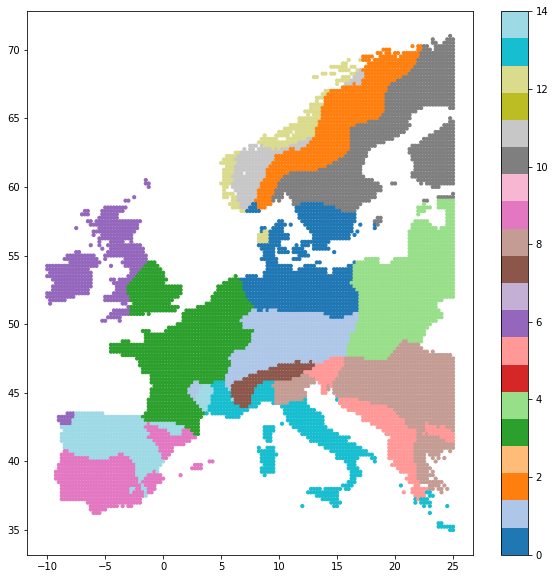

In [106]:
fig,ax = plt.subplots(figsize=(10,10))
aaa = ax.scatter(smoothed_df['Longitude'],smoothed_df['Latitude'],
                 c=np.ma.masked_equal(np.asarray(smoothed_df['cluster_n']),19), cmap='tab20', s=10)
plt.colorbar(aaa)
plt.show()

In [136]:
from copy import deepcopy
smoothed_df_2 = deepcopy(smoothed_df)

# Manual region smoothing - 1
auverge_index = (smoothed_df_2)[smoothed_df_2['cluster_n']==1][smoothed_df_2['Longitude']<5].index
smoothed_df_2.loc[auverge_index,"cluster_n"] = 13
# Manual region smoothing - 2
languedoc_index = (smoothed_df_2)[smoothed_df_2['cluster_n']==14][smoothed_df_2['Longitude']>2.8].index
smoothed_df_2.loc[languedoc_index,"cluster_n"] = 13
# Manual region smoothing - 3
istanbul_index = (smoothed_df_2)[smoothed_df_2['cluster_n']==5][smoothed_df_2['Longitude']>22.3][smoothed_df_2['Latitude']>41].index
smoothed_df_2.loc[istanbul_index,"cluster_n"] = 8
# Manual region smoothing - 4
jutland_index = (smoothed_df_2)[smoothed_df_2['cluster_n']==12][smoothed_df_2['Latitude']<58].index
smoothed_df_2.loc[jutland_index,"cluster_n"] = 0
# Manual region smoothing - 4
tromso_index = (smoothed_df_2)[smoothed_df_2['cluster_n']==11][smoothed_df_2['Latitude']>65].index
smoothed_df_2.loc[tromso_index,"cluster_n"] = 12
# Manual region smoothing - 5
murcia_index = (smoothed_df_2)[smoothed_df_2['cluster_n']==14][smoothed_df_2['Latitude']<38.5].index
smoothed_df_2.loc[murcia_index,"cluster_n"] = 9
# Manual region smoothing - 6
greece_index = (smoothed_df_2)[smoothed_df_2['cluster_n']==13][smoothed_df_2['Longitude']>20].index
smoothed_df_2.loc[greece_index,"cluster_n"] = 5

/tmp/ipykernel_2354240/119521614.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  auverge_index = (smoothed_df_2)[smoothed_df_2['cluster_n']==1][smoothed_df_2['Longitude']<5].index
/tmp/ipykernel_2354240/119521614.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  languedoc_index = (smoothed_df_2)[smoothed_df_2['cluster_n']==14][smoothed_df_2['Longitude']>2.8].index
/tmp/ipykernel_2354240/119521614.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  istanbul_index = (smoothed_df_2)[smoothed_df_2['cluster_n']==5][smoothed_df_2['Longitude']>22.3][smoothed_df_2['Latitude']>41].index
/tmp/ipykernel_2354240/119521614.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  jutland_index = (smoothed_df_2)[smoothed_df_2['cluster_n']==12][smoothed_df_2['Latitude']<58].index
/tmp/ipykernel_2354240/119521614.py:17: UserWarning: Boolean Series key will be reindexed to m

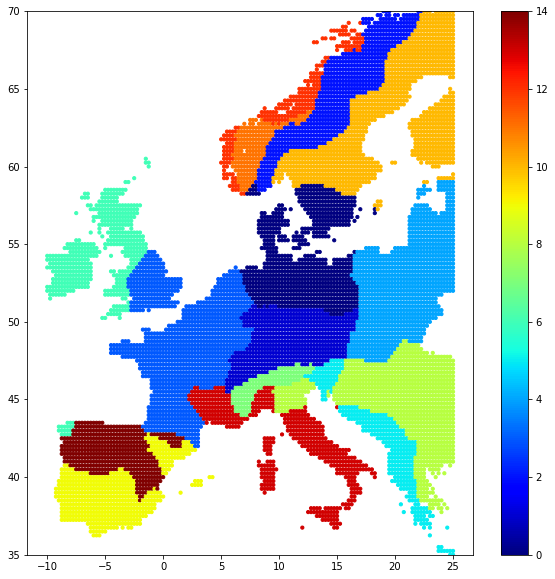

In [137]:
fig,ax = plt.subplots(figsize=(10,10))
aaa = ax.scatter(smoothed_df_2['Longitude'],smoothed_df_2['Latitude'],
                 c=np.ma.masked_equal(np.asarray(smoothed_df_2['cluster_n']),19), cmap='jet', s=10)
plt.colorbar(aaa)
plt.ylim(35,70)
plt.show()

In [138]:
smoothed_df_2.to_csv('../number_of_clusters/cleaned_cluster_15_v2.csv')

# Evaluate purity

In [77]:
from sklearn.metrics import silhouette_score

def evaluate_silhouette_score(df, n_neighbors):
    smoothed_df = smooth_clusters(df, n_neighbors=n_neighbors)
    coords = smoothed_df[['Longitude', 'Latitude']].values
    clusters = smoothed_df['cluster'].values
    return silhouette_score(coords, clusters)

# Example: Test multiple filter sizes
filter_sizes = range(3, 60)
scores = [evaluate_silhouette_score(test, n) for n in filter_sizes]

In [76]:
scores

[0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.10147015167722974,
 0.1014701